In [2]:
import networkExpansionPy.lib as ne
import numpy as np
import pandas as pd
import pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr,pearsonr,mannwhitneyu
from statsmodels.stats.multitest import multipletests
plt.rcParams['font.family'] = 'Arial'
import pingouin as pg
import re


import warnings
from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
warnings.simplefilter('ignore',SparseEfficiencyWarning)

def load_data(network_name):
    with open(ne.asset_path  + "/metabolic_networks/" + network_name,"rb") as filehandler:
        metabolism = pickle.load(filehandler)
    return metabolism

# load the metabolism object from the repo
model_id = "metabolism.v8.01May2023.pkl"
metabolism = pd.read_pickle('/Users/joshuagoldford/Documents/github/network-expansion-assets/models/' + model_id)
cids = metabolism.coenzymes

In [6]:
seed = pd.read_csv('../assets/seed_set.csv')
#background = seed[seed["Type"].isin(["Background"])].ID.tolist()
#cpd_base = seed[~seed["Type"].isin(['Sulfur source',"Nitrogen source"])].ID.tolist()
carbon_compounds = seed[~seed["Type"].isin(["Organic carbon"])].ID.tolist()

def get_c_num(formula):
    match = re.search('C(\d+)', formula)
    if match:
        return  match.group(1)
    else:
        return None

# get only the compounds with CHO in the formula
DOR = pd.read_csv("../assets/keggCHOmolecules.reductionState.csv",index_col=0)
DOR["c"]= DOR.formula.apply(lambda x: get_c_num(x))
DOR = DOR[~DOR.c.apply(lambda x: x is None)]
DOR["c"] = DOR.c.apply(int)

In [11]:
from random import sample
# sample random seed sets
seed_set_base = seed.ID.tolist()
cpd_population = [x for x in DOR.cid.tolist() if x not in seed_set_base]
N = 10
sample_num = 1000
sample_types = []
seed_sets = []
for i in range(sample_num):
    seed_cpds = sample(cpd_population,N)
    seed_sets.append(seed_cpds)
    
seed_sets_full = [x +seed_set_base for x in seed_sets]

In [13]:
compounds,reactions = metabolism.run_expansions_parallel(seed_sets_full,algorithm="trace")

In [15]:
module_set = pd.read_csv('../assets/carbonFixationModuleRules.v2.csv')
carbon_fixation = ['M00165','M00173','M00374','M00375','M00376','M00377','ReductiveGlycineModule']
# this is a biotin-dependent step, whcih can be performed via PEP carboxylase which always occurs earlier
module_set = module_set[~(module_set["step"] == "C00022 -> C00036")]
module_names = {}
module_names['M00165'] = 'Calvin cycle'
module_names['M00173'] = 'Reductive citrate cycle'
module_names['M00374'] = 'Dicarboxylate-hydroxybutyrate cycle'
module_names['M00375'] = 'Hydroxypropionate-hydroxybutylate cycle'
module_names['M00376'] = 'Hydroxypropionate bi-cycle'
module_names['M00377'] = 'Reductive acetyl-CoA pathway'
module_names['ReductiveGlycineModule'] = 'Reductive glycine pathway'
module_set = module_set[module_set.module.isin(list(module_names) + ['M00357.v1','M00357.v2'])]

def carbon_fixation_timing(ne_rxns):
    
    # parse data into dataframes
    rn_df = pd.DataFrame(pd.Series(ne_rxns),columns = ['iteration'])
    rn_df.reset_index(inplace=True)
    rn_df.columns = ['rn','direction','iteration']
    rn_df['rn_kegg']= rn_df['rn'].apply(lambda x: x.split('_')[0])

    
    iterations = rn_df.iteration.unique().tolist()
    module_coverage = {'module':[],'iteration':[],'coverage':[]}


    # make a reaction df with ONLY extant reactions
    rn_df_extant = rn_df[~rn_df.rn.apply(lambda x: ("H2Red" in x) | ("_RSH" in x))]


    for i in iterations:
        rsub = rn_df_extant[rn_df_extant.iteration < (i+1)]
        #rsub =rn_df[rn_df.iteration < (i+1)]
        rsub = rsub.rn_kegg.unique()
        for module,mdf in module_set.groupby('module'):
            z = mdf.reactions.apply(lambda x: any([y in rsub for y in x.split(',')]))
            coverage = z.sum() / len(z)
            module_coverage['module'].append(module)
            module_coverage['iteration'].append(i)
            module_coverage['coverage'].append(coverage)

    module_coverage = pd.DataFrame(module_coverage)
    module_coverage_piv = module_coverage.pivot_table(index='iteration',columns='module',values='coverage')

    M00357 = pd.DataFrame(module_coverage_piv[['M00357.v1','M00357.v2']].max(axis=1))
    M00357.columns = ['coverage']
    M00357['module'] = 'M00357'

    module_coverage = pd.concat([module_coverage,M00357.reset_index()[['module','iteration','coverage']]],axis=0)
    module_coverage_piv = module_coverage.pivot_table(index='iteration',columns='module',values='coverage')

    pathway_completion_iteration = pd.Series({x:y[y.coverage == 1].iteration.min() for x,y in module_coverage.groupby('module')})
    mods = carbon_fixation
    q = pd.DataFrame(pathway_completion_iteration.loc[mods].sort_values(),columns = ['iteration']).reset_index().reset_index()
    q.columns = ['rank','module','iteration']
    return q
 

In [23]:
module_set

,Unnamed: 0,reactions,step,module
0,0,R01523,C00199 -> C01182,M00165
1,1,R00024,C01182 + C00011 -> C00197,M00165
2,2,R01512,C00197 -> C00236,M00165
3,3,"R01061,R01063",C00236 -> C00118,M00165
4,4,R01068,C00118 -> C00354,M00165
...,...,...,...,...
125,4,R01221,C00143 + C00014 + C00011 -> C00037 + C00101,ReductiveGlycineModule
126,5,R07226,C00037 + C00009 -> C00227 + C00014,ReductiveGlycineModule
127,6,R00315,C00008 + C00227 -> C00002 + C00033,ReductiveGlycineModule
128,7,R00235,C00033 -> C00024,ReductiveGlycineModule


In [21]:
# for each simulation, compute the iteration when each C-fixation is feasible
i = 1
pathway_information= []
for r in reactions:
    R = carbon_fixation_timing(r)
    R["expansion"] = i
    i+=1
    pathway_information.append(R)
    
pathway_information = pd.concat(pathway_information,axis=0)

KeyboardInterrupt: 

In [24]:
pathway_information = pd.concat(pathway_information,axis=0)

In [27]:
len(pathway_information)

2044

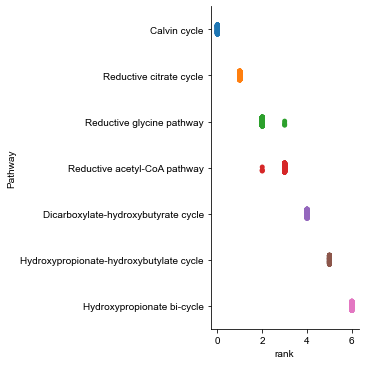

In [26]:
# rename modules
pathway_information["Pathway"] = pathway_information["module"].apply(lambda x: module_names[x])
sns.catplot(y='Pathway',x='rank',data=pathway_information)

In [36]:
pathway_results = pd.read_csv("data/random_seed_sets_pathway_ordering/04May2023/pathway_results.csv")
pathway_results.columns = ["rank","module","iteration","expansion"]
pathway_results["rank"] = pathway_results["rank"]+1
pathway_results["Pathway"] = pathway_results["module"].apply(lambda x: module_names[x])


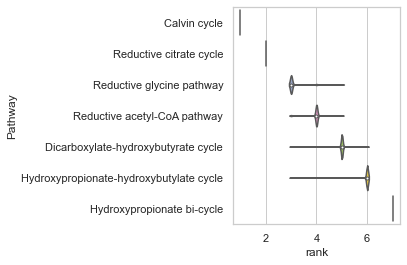

In [76]:

pathway_results = pd.read_csv("data/random_seed_sets_pathway_ordering/07May2023/pathway_results.csv")
pathway_results.columns = ["rank","module","iteration","expansion"]
pathway_results["rank"] = pathway_results["rank"]+1
pathway_results["Pathway"] = pathway_results["module"].apply(lambda x: module_names[x])

order = pathway_results.groupby("Pathway").mean().sort_values("rank").index.tolist()
plt.figure(figsize=(3,4))
sns.violinplot(y='Pathway',x='rank',data=pathway_results,order=order,palette="Set2",height=3,aspect=1)
plt.savefig("data/random_seed_sets_pathway_ordering/07May2023/distribution.svg")


In [71]:
#sns.boxplot(y='Pathway',x='rank',data=pathway_results,order=order,palette="Set2",height=5,aspect=1)


In [68]:
#pathway_results.dropna()